In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: TkAgg


# Lab 8
### Ian Eykamp

   Vg (V)  Ig (A)  Vout (V)   Pg (W)  Iout (A)  Pout (W)  Efficiency (%)
0   18.05   1.454     10.16  26.2447     2.032  20.64512       78.663959
1   17.00   1.495     10.00  25.4150     2.000  20.00000       78.693685
2   16.00   1.590     10.00  25.4400     2.000  20.00000       78.616352
3   15.00   1.707     10.00  25.6050     2.000  20.00000       78.109744
4   14.00   1.834     10.00  25.6760     2.000  20.00000       77.893753
5    9.43   1.760     10.00  16.5968     2.000  20.00000      120.505158


(76.0, 81.0)

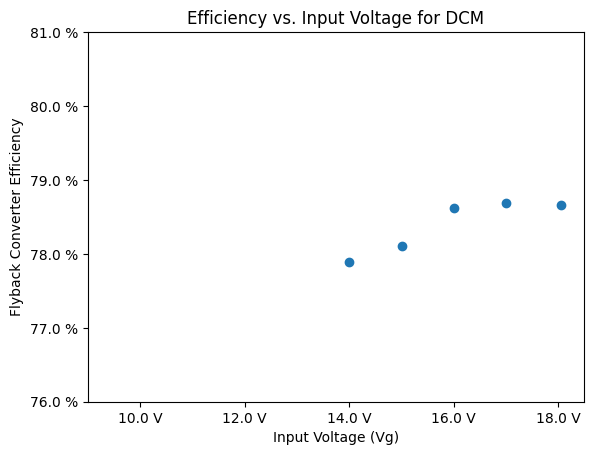

In [69]:
Rload = 5 # Ohms
power_measurements = pd.read_csv("input_current_voltage.csv")
power_measurements["Pg (W)"] = power_measurements["Vg (V)"] * power_measurements["Ig (A)"]
power_measurements["Iout (A)"] = power_measurements["Vout (V)"] / Rload
power_measurements["Pout (W)"] = power_measurements["Vout (V)"] * power_measurements["Iout (A)"]
power_measurements["Efficiency (%)"] = power_measurements["Pout (W)"] / power_measurements["Pg (W)"] * 100
# power_measurements.drop(index = 5, inplace = True) # get rid of bogus last value which gave 120% efficiency
print(power_measurements)

plt.figure()
helper.axes_labels("Input Voltage (Vg)", "V", "Flyback Converter Efficiency", "%", title = "Efficiency vs. Input Voltage for DCM")
plt.scatter(power_measurements["Vg (V)"], power_measurements["Efficiency (%)"])
plt.ylim([76, 81])

## Oscilloscope Data

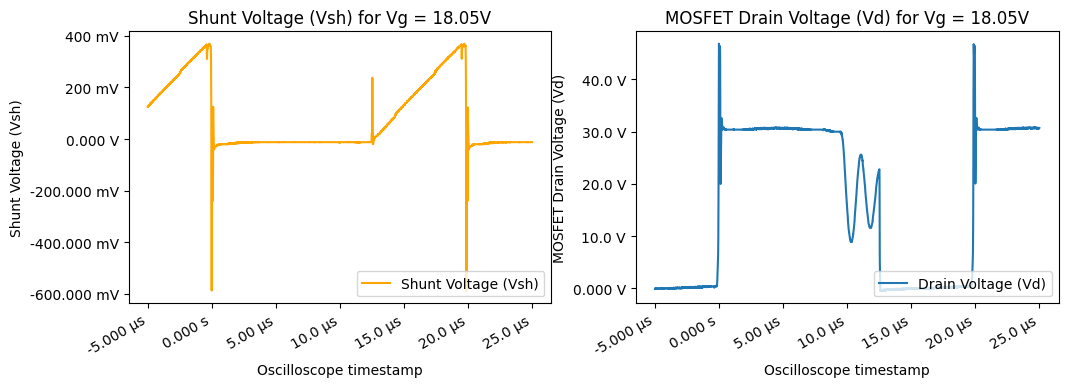

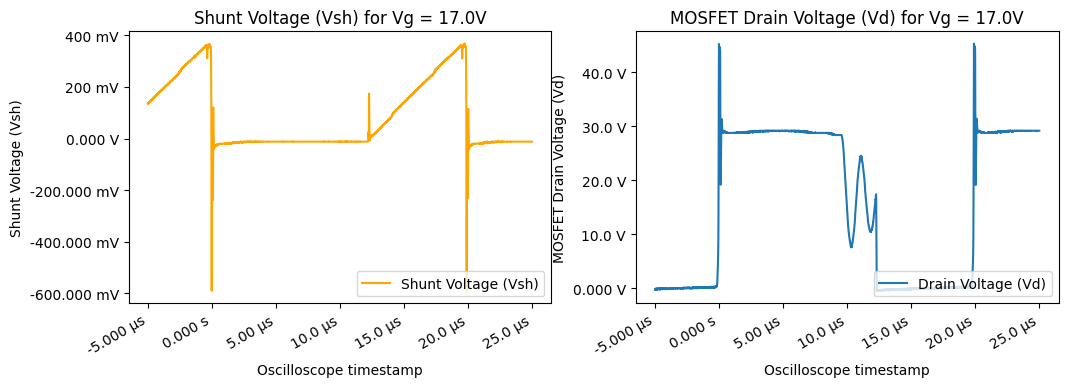

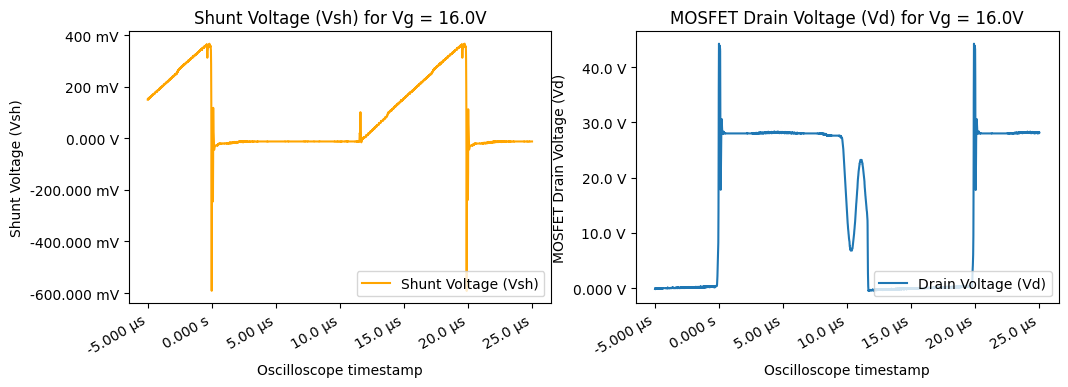

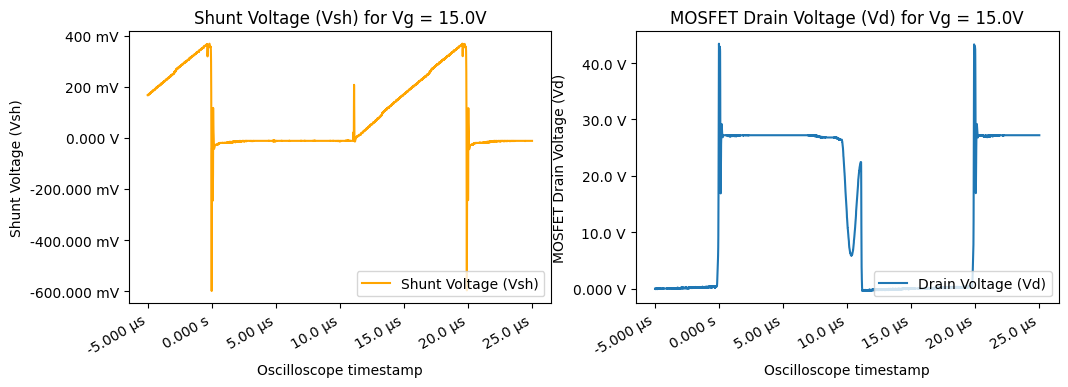

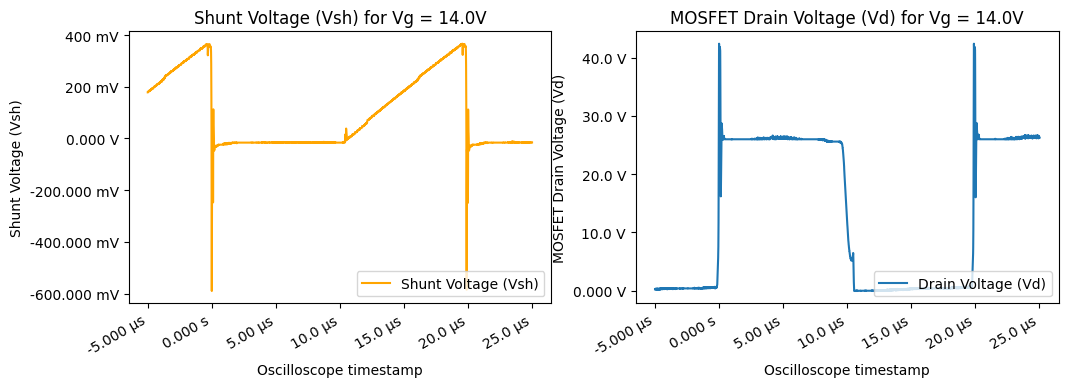

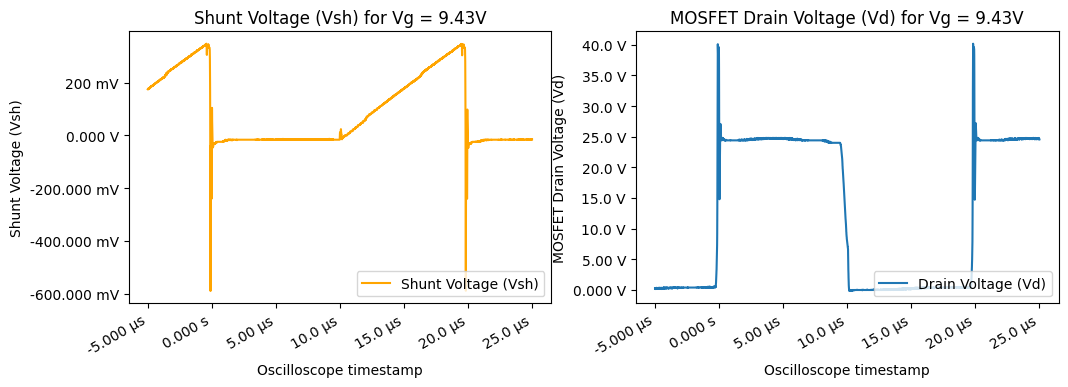

In [70]:
filenames = ["Newfile59", "Newfile60", "Newfile1", "Newfile2", "Newfile3", "Newfile4"]

for index, row in power_measurements.iterrows():
    (df_oscilloscope, tspan, tstep) = helper.read_rigol_csv(f"oscilloscope_data/{filenames[index]}.csv", ch1 = "Vsh", ch2 = "Vd")
    df_zoom = df_oscilloscope[(df_oscilloscope["t"] > -5e-6) & (df_oscilloscope["t"] < 25e-6)]

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False, figsize = (12, 4))
    fig.autofmt_xdate()
    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = f"Shunt Voltage (Vsh) for Vg = {row['Vg (V)']}V", ax = ax1)
    ax1.plot(df_zoom["t"], df_zoom["Vsh"], color = "orange", label = "Shunt Voltage (Vsh)")
    ax1.legend(loc = "lower right")

    helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = f"MOSFET Drain Voltage (Vd) for Vg = {row['Vg (V)']}V", ax = ax2)
    ax2.plot(df_zoom["t"], df_zoom["Vd"], label = "Drain Voltage (Vd)")
    ax2.legend(loc = "lower right")
    